# Introduction to SunPy - `Map`

## Useful Links

1. [SunPy Map Documentation](http://docs.sunpy.org/en/stable/guide/data_types/maps.html)
1. [SunPy Example Gallery](http://docs.sunpy.org/en/stable/generated/gallery/index.html)

## Working with solar data

The core of SunPy's functionality is that it provides three objects for dealing with solar data types: `Map` for solar image data, `Lightcurve` for time-series data and `Spectra` for spectral data. Today we'll be focusing exclusively on `Map`, which is the most used and most developed, but it is worth being aware that the others exist should you need them.

SunPy also provides several sample data files, which need to be manually downloaded. For this example we'll use the sample AIA 17.1nm image.

In [1]:
# Import statements
import sunpy.map
from sunpy.data import download_sample_data

# This is needed to download the sample data
#download_sample_data()

Once the sample data has been downloaded, you can import the `AIA_171_IMAGE` variable. Notice that this is not the image itself, but a string corresponding to the location of the image on disk. A `Map` object is created by passing `Map()` the filename of a valid fits image file, such as the one defined in `AIA_171_IMAGE`.

In [2]:
from sunpy.data.sample import AIA_171_IMAGE

print(AIA_171_IMAGE)
mymap = sunpy.map.Map(AIA_171_IMAGE)

print(mymap)

/home/drew/sunpy/data/sample_data/AIA20110319_105400_0171.fits
[[ 0.3125 -0.0625 -0.125  ...,  0.625  -0.625   0.    ]
 [ 1.      0.1875 -0.8125 ...,  0.625  -0.625   0.    ]
 [-1.1875  0.375  -0.5    ..., -0.125  -0.625  -1.1875]
 ..., 
 [-0.625   0.0625 -0.3125 ...,  0.125   0.125   0.125 ]
 [ 0.5625  0.0625  0.5625 ..., -0.0625 -0.0625  0.    ]
 [ 0.5    -0.125   0.4375 ...,  0.6875  0.6875  0.6875]]


The two most important attributes of this new variable are `mymap.data`, which contains an array of the pixel values of the image, and `mymap.meta`, which contains the header information. Both of these are loaded from the specified file.

In [ ]:
print(mymap.data)
print(mymap.meta)

The disadvantage with FITS headers is that they're made to be rad by a computer rather than a human, so it isn't always immediately clear what a particular keyword refers to. Fortunately, Map has a lot of attributes which reproduce the metadata in a more useable format, so in practice you shouldn't often have to deal with `Map.meta` directly. For instance:

In [ ]:
print(mymap.date) # Nicer than mymap.meta['t_obs']
print(mymap.coordinate_system) # Nicer than mymap.meta['ctype1'], mymap.meta['ctype2']

`Map` also has some attributes and methods which reproduce functionality of NumPy arrays, so you can work with map data in many of the same ways as we've been working with arrays in previous sessions:

In [ ]:
print(mymap.min(), mymap.mean(), mymap.max(), mymap.std())

## Displaying Maps

Now let's get back to displaying data. There are two methods for plotting and displaying a `Map`. The first is `peek()`. This method is quick and easy to use, and automatically does a few things to make the plot look nice - it adds a title, sensible axes labels, a colourbar and a coordinate grid.

<IPython.core.display.Javascript object>


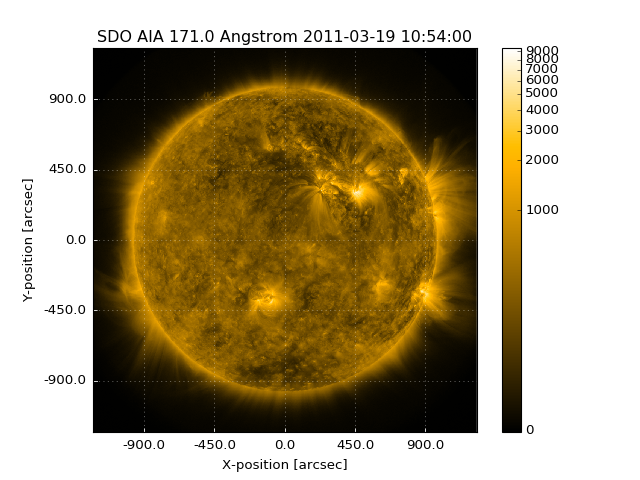

In [3]:
import matplotlib.pyplot as plt
%matplotlib notebook

mymap.peek()

This is useful for quickly inspecting data, but can't really be customised much past this stage, so it isn't very flexible.

The other plotting method, `plot()`, produces a very slightly simpler plot by default:

In [ ]:
fig = plt.figure()
mymap.plot()
plt.show()

But the advantage of using this method is that it provides a plot that can be customised in many of the same ways as a normal line or image plot. This can be done with various functions in `pyplot`, and by passing keyword arguments to the `plot()` function.

In [ ]:
fig, ax = plt.subplots()
mymap.plot(vmin=500, vmax=1000)
ax.set_title('The Sun')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.set_cmap('Oranges_r')
plt.colorbar()
plt.show()

### Adjusting `Map`s

#### Rotation

Quite often you may want to adjust the rotation of a `Map`, either to account for some known effect or to align multiple images. `Map`s have a dedicated method for this task, `Map.rotate()`, which can take an angle as argument and returns a new `Map`, rotated by that amount anti-clockwise. In the new `Map`, all the relevant header information is updated accordingly, so you never need to adjust it yourself when manipulating your data. In particular, the header stores the rotation of the data, and this is accessible through the `Map.rotation_matrix` attribute.

In [16]:
import numpy as np
import astropy.units as u

rotated_map = mymap.rotate((np.pi/6)*u.rad)
print(mymap.rotation_matrix)
print(rotated_map.rotation_matrix)

[[ 1. -0.]
 [ 0.  1.]]
[[ 0.8660254  0.5      ]
 [-0.5        0.8660254]]


If we plot the initial and rotated `Map`s, we can also see that the coordinate information has been updated.

In [ ]:
# Draw lon-lat grids on plots to highlight the rotation
mymap.peek(draw_grid=True)
rotated_map.peek(draw_grid=True)

You may also notice here that the `Map` has expanded so that no part of the original array is lost by the rotation.

If you decide you want to reverse the rotation, the default behaviour of `Map.rotate()` makes this even easier. When no argument is provided, `rotate()` performs whatever rotation is required to reverse the current rotation of the `Map`.

In [ ]:
restored_map = rotated_map.rotate()
restored_map.peek(draw_grid=True)

This is also very helpful when you are provided with data which is already rotated, since the header should describe that rotation:

In [ ]:
# Import data from during an AIA roll maneouver
from sunpy.data.sample import AIA_171_ROLL_IMAGE

rollmap = sunpy.map.Map(AIA_171_ROLL_IMAGE)
print(rollmap.rotation_matrix)
rollmap.peek(draw_grid=True)

norollmap = rollmap.rotate()
print(norollmap.rotation_matrix)
norollmap.peek(draw_grid=True)

In [ ]:
rollmap.yrange

### Submaps and coordinate ranges

`Map`s have the very useful functionality of being croppable. Using the `submap` method, you can crop a `Map` to specified coordinates, creating a new map with an updated header, just like when we used `rotate()`.

In [ ]:
# Check some information about the Map first.
print(mymap.mean(), mymap.date, mymap.xrange)

# Crop the Map and store the new one in another variable.
smap = mymap.submap([-200, 0]*u.arcsec, [-450, -250]*u.arcsec)

# Check the same information again
print(smap.mean(), smap.date, smap.xrange)

# Have a look
smap.plot()
plt.show()

First, notice that the `Map` is aware of its own size in physical units: the `xrange` attribute tells us the extent of the data in the x direction and there is a similar `yrange` attribute. You should also notice that the range of the submap is (almost) what we specified when we created it. It doesn't _quite_ match up because the array has to be cropped between pixels and the physical coordinates we specify may not exactly achieve this. But it's very close.

When we rotated a map earlier, the array was expanded to avoid parts of it being cropped unintentionally. This can be annoying, so if you're absolutely sure you don't mind losing that information, you might want to reset the extent of the image to a more sensible value by combining `submap()` and `xrange`/`yrange`.

In [ ]:
restored_map.peek()
newmap = restored_map.submap(mymap.xrange, mymap.yrange)
newmap.peek()

### Overplotting WCS axes

If we plot the rotated map again, we can have a closer look at coordinate grid.

<IPython.core.display.Javascript object>


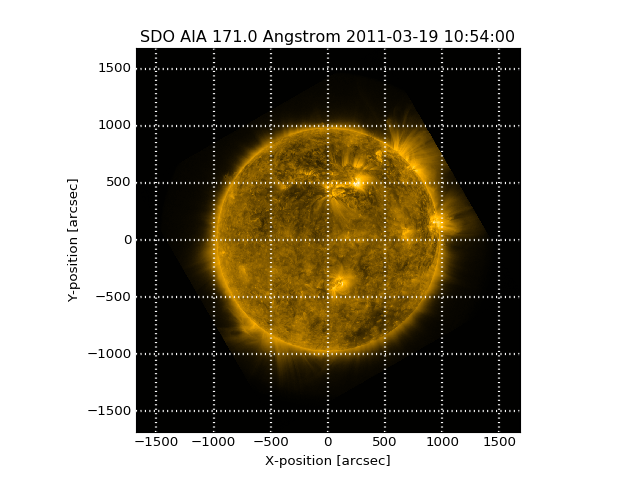

/home/drew/anaconda3/lib/python3.5/site-packages/sunpy/map/mapbase.py:1588: Warning: This map is not properly oriented. Plot axes may be incorrect
  Warning)
/home/drew/anaconda3/lib/python3.5/site-packages/sunpy/map/mapbase.py:1593: Warning: WCSAxes is installed but not being used. Plots may not have the expected behaviour.
  Warning)


In [54]:
fig = plt.figure()
ax = plt.subplot()
# Plot the rotated map on our axes
rotated_map.plot(axes=ax)
# Make the coordinate grid more visible
ax.grid(color='white', linewidth=2)
plt.show()

This grid is in image coordinates, which is great but doesn't tell us anything about the rotation of the image. For that, we need to use the WCS (World Coordinate System) information included in the `Map`.

When we create a subplot, we can specify a projection. Normally this will be something like cartesian or polar, but for solar data we can specify a coordinate system. We can create one, but `Map` includes this information for us, so we can pass it straight into `subplot()`.

<IPython.core.display.Javascript object>


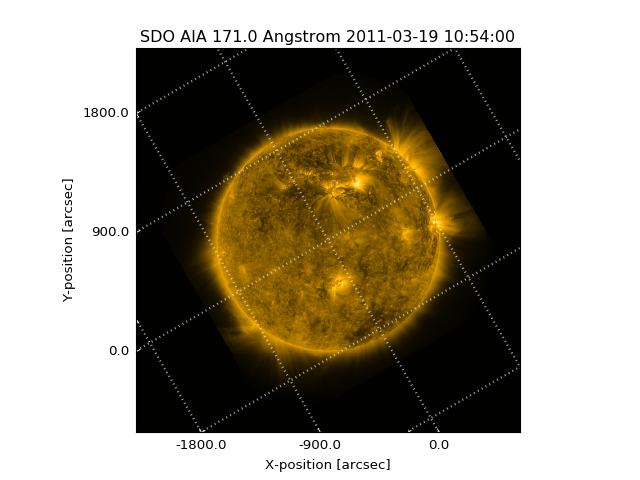

In [57]:
fig = plt.figure()
ax = plt.subplot(projection=rotated_map.wcs)
rotated_map.plot(axes=ax)
ax.grid(linewidth=2)
plt.show()

Now we can see that we have a different grid overlaid on the plot - now it's aligned withe the rotation.

## Challenge: Putting it all together

1. Plot the sample AIA 17.1nm image, next to a submap of some interesting feature from that image. Give both plots a colourbar and change the titles. 
1. Plot a black cross at the same point on both images.
1. Plot a rectangle on the full `Map` which corresponds to the edges of the submap.

**Hints:**
- You can specify an axes to draw on by passing it into `plot()`, like this: `mymap.plot(axes=ax)`
- `Map` has a `draw_rectangle()` method.
- `matplotlib` can be fussy about astropy units - you'll often have to use just the value of a Quantity in order for the plotting functions to work properly.

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

mymap.plot(axes=ax[0]) # Plot the full Map
plt.title('Full sun') # Change the title
plt.colorbar() # Show a colour bar
plt.plot(-85, -380, marker='x', color='black') # Plot a single point with a black cross
# Plotting a line over a Map messes up the axes limits and they have to be reset
plt.xlim(mymap.xrange.value)
plt.ylim(mymap.yrange.value)
# Define the bottom-left corner, width and height of a rectangle from the ranges of the submap
corner = [smap.xrange[0].value, smap.yrange[0].value] * u.arcsec
width = smap.xrange[1] - smap.xrange[0]
height = smap.yrange[1] - smap.yrange[0]
mymap.draw_rectangle(corner, width, height) # Draw the rectangle

# Same again on the right
smap.plot(axes=ax[1])
plt.title('Active region')
plt.colorbar()
plt.plot(-85, -380, 'bx')
plt.xlim(smap.xrange.value)
plt.ylim(smap.yrange.value)

plt.show()